# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 29, 11:59PM

### Name: Ethan Che

I pledge my honor that I have abided by the Stevens Honor System.


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np
import tensorflow as tf

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    hot = []
    for x in y: #For every element in input array
        temp = []
        for i in range(10):
            if (i == x[0]):
                temp.append(1)
            else:
                temp.append(0)
        hot.append(temp)
    return hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(np.shape(y_train_vec)))
print('Shape of y_test_vec: ' + str(np.shape(y_test_vec)))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=18)

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

y_tr_vec = to_one_hot(y_tr)
y_val_vec = to_one_hot(y_val)

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 1)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 1)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [4]:
# Build the model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (32, 32, 3))) #3-by-3 convolution to get from 32x32 to 30x30
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (4,4), activation='relu', input_shape=(15,15,32)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [5]:
# Define model optimizer and loss function

model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.0008),loss='categorical_crossentropy',metrics=['accuracy'])

In [6]:
# Train the model and store model parameters/loss values
history = model.fit(np.array(x_tr), np.array(y_tr_vec), batch_size=256, epochs=50, validation_data=(np.array(x_val), np.array(y_val_vec)))

bsize = 256 #parameters to use
lr = 0.0008


Epoch 1/50
157/157 [==============================] - 13s 13ms/step - loss: 4.3764 - accuracy: 0.2267 - val_loss: 1.9562 - val_accuracy: 0.3164
Epoch 2/50
157/157 [==============================] - 2s 11ms/step - loss: 1.7716 - accuracy: 0.3929 - val_loss: 1.5633 - val_accuracy: 0.4527
Epoch 3/50
157/157 [==============================] - 2s 10ms/step - loss: 1.4096 - accuracy: 0.5075 - val_loss: 1.8283 - val_accuracy: 0.4127
Epoch 4/50
157/157 [==============================] - 2s 10ms/step - loss: 1.1843 - accuracy: 0.5919 - val_loss: 1.6482 - val_accuracy: 0.4434
Epoch 5/50
157/157 [==============================] - 2s 10ms/step - loss: 0.9783 - accuracy: 0.6634 - val_loss: 1.3716 - val_accuracy: 0.5530
Epoch 6/50
157/157 [==============================] - 2s 10ms/step - loss: 0.8014 - accuracy: 0.7252 - val_loss: 1.3167 - val_accuracy: 0.5861
Epoch 7/50
157/157 [==============================] - 2s 10ms/step - loss: 0.6437 - accuracy: 0.7811 - val_loss: 1.5422 - val_accuracy: 0.572

## 3. Plot the training and validation loss curve versus epochs. (5 points)

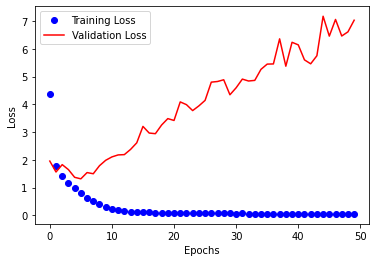

In [7]:
# Plot the loss curve
import matplotlib.pyplot as plt
epochs = range(50)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [8]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model.compile(tf.keras.optimizers.RMSprop(learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
#<Train your model on the entire training set (50K samples)>
history = model.fit(np.array(x_train), np.array(y_train_vec), batch_size=bsize, epochs=50)

Epoch 1/50
196/196 [==============================] - 3s 12ms/step - loss: 0.8352 - accuracy: 0.8651
Epoch 2/50
196/196 [==============================] - 3s 13ms/step - loss: 0.3819 - accuracy: 0.9141
Epoch 3/50
196/196 [==============================] - 2s 12ms/step - loss: 0.2281 - accuracy: 0.9407
Epoch 4/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1543 - accuracy: 0.9589
Epoch 5/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1124 - accuracy: 0.9681
Epoch 6/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1049 - accuracy: 0.9721
Epoch 7/50
196/196 [==============================] - 2s 9ms/step - loss: 0.0858 - accuracy: 0.9761
Epoch 8/50
196/196 [==============================] - 2s 9ms/step - loss: 0.0829 - accuracy: 0.9781
Epoch 9/50
196/196 [==============================] - 2s 9ms/step - loss: 0.0815 - accuracy: 0.9783
Epoch 10/50
196/196 [==============================] - 2s 9ms/step - loss: 0.0720 - accuracy: 0.9

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model.evaluate(np.array(x_test), np.array(y_test_vec), batch_size=1)

print('Test accuracy = ' + str(loss_and_acc[1]))

10000/10000 [==============================] - 23s 2ms/step - loss: 10.1678 - accuracy: 0.6497
Test accuracy = 0.6496999859809875


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)             

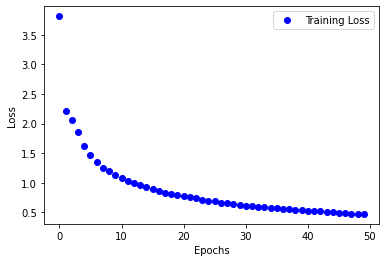

10000/10000 [==============================] - 22s 2ms/step - loss: 1.0348 - accuracy: 0.6765
Test accuracy = 0.6765000224113464


In [11]:
#New model version 1: add a dropout layer
import matplotlib.pyplot as plt
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (32, 32, 3))) #3-by-3 convolution to get from 32x32 to 30x30
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (4,4), activation='relu', input_shape=(15,15,32)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.0008),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(np.array(x_train), np.array(y_train_vec), batch_size=256, epochs=50)
epochs = range(50)

train_loss = history.history['loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
loss_and_acc = model.evaluate(np.array(x_test), np.array(y_test_vec), batch_size=1)

print('Test accuracy = ' + str(loss_and_acc[1]))


#As we can see, adding one dropout layer increases the testing accuracy to around 70%


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                      

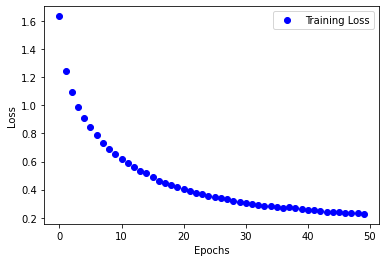

10000/10000 [==============================] - 23s 2ms/step - loss: 1.2535 - accuracy: 0.6910
Test accuracy = 0.6909999847412109


In [12]:
#New model version 2: add a batch normalization layer at the start
import matplotlib.pyplot as plt
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3,3), input_shape = (32, 32, 3))) #3-by-3 convolution to get from 32x32 to 30x30
model2.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D(2,2))
model2.add(layers.Conv2D(64, (4,4), activation='relu', input_shape=(15,15,32)))
model2.add(layers.MaxPooling2D(2,2))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))
model2.summary()

model2.compile(tf.keras.optimizers.RMSprop(learning_rate=0.0008),loss='categorical_crossentropy',metrics=['accuracy'])
history = model2.fit(np.array(x_train), np.array(y_train_vec), batch_size=256, epochs=50)
epochs = range(50)

train_loss = history.history['loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
loss_and_acc = model2.evaluate(np.array(x_test), np.array(y_test_vec), batch_size=1)

print('Test accuracy = ' + str(loss_and_acc[1]))


#Adding the BN layer gives us another increase in testing accuracy